In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import requests
import StringIO

## Entropy

Classically, entropy is a measure of disorder in a system.  From a statistical perspective, it is more useful to say it's a measure of the unpredictability of the system.  In this episode we discuss how information reduces the entropy in deciding whether or not Yoshi the parrot will like a new chew toy.  A few other everyday examples help us examine why entropy is a nice metric for constructing a decision tree.

### Definition

Formally, the entropy $H$ of a system $X$ is given by summing over every value/state of the system, the likelihood of observing a given value $x_i$ times the log of that likelihood.

$H(X) = - \sum\limits_{i=1}^n P(x_i) \cdot \text{log}_2 P(x_i)$

### Entropy in a fair coin toss

If we consider the example of a coin toss, the we have

$X = \{H, T\}$

$Pr(X=H) = 0.5$
$Pr(X=T) = 0.5$

Thus...

$H(x) = -\Big( P(X=H) \cdot \text{log}_2 P(X=H) \Big) + -\Big( P(X=T) \cdot \text{log}_2 P(X=T) \Big) = -\Big( 0.5 \cdot -1.0 \Big) + -\Big(0.5 \cdot -1.0 \Big) = 1$

### Entropy in an unfair coin toss

If you are dealing with an outcome that is binary, but biased (i.e. not 50/50), you'll end up with the following values of Entropy $H$ given the weighting of the coin.

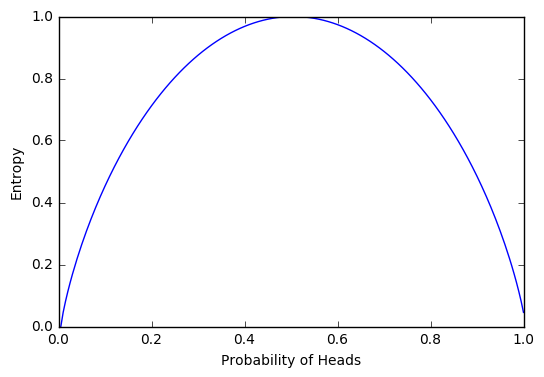

In [41]:
prob_h = 1.0 * np.arange(200) / 200
h_x = - prob_h * map(lambda x: 0 if x==0 else math.log(x, 2), prob_h) + -1 *(1-prob_h) * map(lambda x: math.log(x, 2), (1-prob_h))
plt.plot(prob_h, h_x)
plt.xlabel("Probability of Heads")
plt.ylabel("Entropy")
plt.show()

It's interesting to consider, instead, a six sided die.

$X = \{1, 2, 3, 4, 5, 6\}$

$Pr(x_i) = \dfrac{1}{6}$

Let $b = 6$

$H(x) = - \sum\limits_{i=1}^6 \dfrac{1}{6} \cdot \text{log}_b \dfrac{1}{6} \approx 2.58$

In this way, we can see that there is more entropy in a fair die because we require more bits of information to describe the outcome.

### Use of Entropy in Decision Tree Learning

A decision tree is a series of questions that lead us to a classification result.  If we choose decision trees as our method, we want to produce a model that has a controlled number of nodes in the tree to avoid overfitting.  We can accomplish this by splitting our dataset into smaller sets in such a way that gives us the best information gain.  In other words, if asking a paricular question of the data makes us significantly better able to predict the resulting classification, then the split is useful to us because it makes the outcome more predictable by reducing entropy.

Let's take a look at how this applies to the classic [Auto MPG Data Set](https://archive.ics.uci.edu/ml/datasets/Auto+MPG).  We'll do this by hand since we're interested more in entropy today than in the decision tree algorithm itself.

In [43]:
r = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

In [62]:
handle = StringIO.StringIO(r.content)
names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'car name']
df = pd.read_fwf(handle, colspecs='infer', names=names)

In [63]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


For the purposes of demonstration, let's introduce a class label called `fuel_economy` which considers anything about 25 miles per gallon good, and everything else bad.

In [67]:
df['fuel_economy'] = df['mpg'].apply(lambda x: 'good' if x > 25 else 'bad')

Let's first calculate the entropy of this metric before considering any of the features.

In [90]:
agg = df.groupby(['fuel_economy']).agg({'mpg': ['count']})
norm = agg / agg.sum()
entropy_initial = norm['mpg']['count'].apply(lambda x: -x * math.log(x)).sum()
print(entropy_initial)

0.671770204228


We can calulate the initial entropy to be 0.67177.

Now, let's consider the entropy of the dataset if we split it based on the number of cylinders in the car (which can be 3, 4, 5, 6, or 8).

In [210]:
agg = df.groupby(['cylinders', 'fuel_economy']).agg({'mpg': ['count']})
agg.reset_index(inplace=True)
cylinders = []
entropies = []
for c in set(df.cylinders):
    aggc = agg[agg.cylinders == c].copy()
    aggc.reset_index(inplace=True)
    aggc['p'] = 1.0 * aggc['mpg']['count'] / aggc['mpg']['count'].sum()
    values = map(lambda x: -1 * (x * math.log(x, 2)), aggc.p)
    entropy = reduce(lambda a, b: a + b, values)
    cylinders.append(c)
    entropies.append(entropy)

result = pd.DataFrame({'cylinders': cylinders, 'entropy': entropies})
result.sort_values(by='cylinders', inplace=True)
result.set_index('cylinders', inplace=True)
observations = pd.DataFrame(df.groupby(['cylinders'])['mpg'].count())
observations.columns = ['count']
df2 = pd.concat([result, observations], axis=1)
df2['freq'] = 1.0 * df2['count'] / df2['count'].sum()
df2['weighted_entropy'] = df2['freq'] * df2['entropy']
df2

,entropy,count,freq,weighted_entropy
cylinders,,,,
3,-0.000000,4,0.010050,-0.000000
4,0.840901,204,0.512563,0.431015
5,0.918296,3,0.007538,0.006922
6,0.371232,84,0.211055,0.078351
8,0.078856,103,0.258794,0.020407


The values above are the entropy of the resulting sub-sets when you split on Cylinders.  Notice that the entropy in 3 cylinder cars is zero.  This is because there are only four observations in the dataset with 3 cylinder engine, and they all have miles per gallon below 25.  If you know the cylinders to be 3, you have no uncertainty.

You will notice that for each subgroup, the entropy given the cylinder count is less in every case than before we did the split.  This isn't to say that cylinders is the best feature to split on, just a demonstration of why Entropy is useful in creating a tree based model.